Number of data in the dataset: 1200
Loading Images. It may take a while, depending on the database size.
loaded 43% of dataset (526/1174). Filtered images: 26
loaded 87% of dataset (1054/1146). Filtered images: 54
Skipped 115 happy class images.
1030 are left after 'strange images' removal.
Deleted 55 strange images. Images are shown below
number of clean data:1030  48x48 pix , 0-255 greyscale images
orig train data (966, 48, 48)
orig train labels (966,)from 0.0 to 5.0
orig test data (64, 48, 48)
orig test labels (64,)from 0.0 to 5.0
TRAIN: number of 0 labels 193
TRAIN: number of 1 labels 149
TRAIN: number of 2 labels 168
TRAIN: number of 3 labels 174
TRAIN: number of 4 labels 111
TRAIN: number of 5 labels 171
TEST: number of 0 labels 13
TEST: number of 1 labels 9
TEST: number of 2 labels 11
TEST: number of 3 labels 15
TEST: number of 4 labels 6
TEST: number of 5 labels 10
train labels shape (966, 6)
test labels shape (64, 6)
W_conv1= (8, 8, 1, 22)
b_conv1= (22,)
x_2d1= (64, 48, 48, 1)

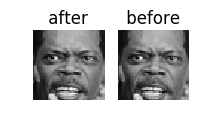

In [1]:
# This notebook is created to analyse the CNN
# @author Patryk Oleniuk, EPFL 2017
#
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy.misc
import time
import collections
import os
import utils as ut
import importlib
import copy

importlib.reload(ut)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# The CSV data (with removed first line ! (names))
emotions_dataset_dir = 'fer2013_shortened.csv'

#obtaining the number of line of the csv file
file = open(emotions_dataset_dir)
numline = len(file.readlines())
print ('Number of data in the dataset:',numline)

#Load the file in csv
ifile  = open(emotions_dataset_dir, "rt")
reader = csv.reader(ifile)

hist_threshold = 350 # images above this threshold will be removed
hist_div = 100 #parameter of the histogram

print('Loading Images. It may take a while, depending on the database size.')
images, emotions, strange_im, num_strange, num_skipped = ut.load_dataset(reader, numline, hist_div, hist_threshold)

ifile.close()

print('Skipped', num_skipped, 'happy class images.')
print(str( len(images) ) + ' are left after \'strange images\' removal.')
print('Deleted ' + str( num_strange ) + ' strange images. Images are shown below')

classes = [0,1,2,3,4,5]
str_emotions = ['angry','scared','happy','sad','surprised','normal']
num_classes = len(classes)
samples_per_class = 6

print('number of clean data:' + str(images.shape[0]) + '  48x48 pix , 0-255 greyscale images')
n_all = images.shape[0];
n_train = 64; # number of data for training and for batch

# dividing the input data
train_data_orig = images[0:n_all-n_train,:,:]
train_labels = emotions[0:n_all-n_train]
test_data_orig = images[n_all-n_train:n_all,:,:]
test_labels = emotions[n_all-n_train:n_all]

# Convert to float
train_data_orig = train_data_orig.astype('float32')
y_train = train_labels.astype('float32')
test_data_orig = test_data_orig.astype('float32')
y_test = test_labels.astype('float32')

print('orig train data ' + str(train_data_orig.shape))
print('orig train labels ' + str(train_labels.shape) + 'from ' + str(train_labels.min()) + ' to ' + str(train_labels.max()) )
print('orig test data ' + str(test_data_orig.shape))
print('orig test labels ' + str(test_labels.shape)+ 'from ' + str(test_labels.min()) + ' to ' + str(test_labels.max()) )

for i in range (0, 6):  
    print('TRAIN: number of' , i, 'labels',len(train_labels[train_labels == i]))

for i in range (0, 6):  
    print('TEST: number of', i, 'labels',len(test_labels[test_labels == i]))
    
# Data pre-processing
n = train_data_orig.shape[0];
train_data = np.zeros([n,48**2])
for i in range(n):
    xx = train_data_orig[i,:,:]
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    train_data[i,:] = xx.reshape(2304); #np.reshape(xx,[-1])

n = test_data_orig.shape[0]
test_data = np.zeros([n,48**2])
for i in range(n):
    xx = test_data_orig[i,:,:]
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    test_data[i] = np.reshape(xx,[-1])

#print(train_data.shape)
#print(test_data.shape)
#print(train_data_orig[0][2][2])
#print(test_data[0][2])
plt.rcParams['figure.figsize'] = (2.0, 2.0) # set default size of plots
plt.subplot(121);
plt.imshow(train_data[9].reshape([48,48]));
plt.title(' after ');
plt.axis('off')
plt.subplot(122);
plt.imshow(train_data_orig[9]);
plt.title(' before ');
plt.axis('off');

# Convert label values to one_hot vector

train_labels = ut.convert_to_one_hot(train_labels,num_classes)
test_labels = ut.convert_to_one_hot(test_labels,num_classes)

print('train labels shape',train_labels.shape)
print('test labels shape',test_labels.shape)

#Definition of function that have been used in the CNN

d = train_data.shape[1]

def weight_variable2(shape, nc10):
        initial2 = tf.random_normal(shape, stddev=tf.sqrt(2./tf.to_float(ncl0)) )
        return tf.Variable(initial2)

def conv2d(x,W):
        return tf.nn.conv2d(x,W,strides=[1, 1, 1, 1], padding='SAME')
    
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=1/np.sqrt(d/2) )
        return tf.Variable(initial)
    
def bias_variable(shape):
    initial = tf.constant(0.01,shape=shape)
    return tf.Variable(initial)

tf.reset_default_graph()

# implementation of Conv-Relu-COVN-RELU - pool
# based on : http://cs231n.github.io/convolutional-networks/

# Define computational graph (CG)
batch_size = n_train    # batch size
d = train_data.shape[1]  # data dimensionality
nc = 6                  # number of classes

# Inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())


#for the first conc-conv
# Convolutional layer
K0 = 8   # size of the patch
F0 = 22  # number of filters
ncl0 = K0*K0*F0

#for the second conc-conv
K1 = 4   # size of the patch
F1 = F0  # number of filters
ncl1 = K1*K1*F1

#drouput probability
keep_prob_input=tf.placeholder(tf.float32)

#1st set of conv followed by conv2d operation and dropout 0.5
W_conv1=weight_variable([K0,K0,1,F0]); print('W_conv1=',W_conv1.get_shape())
b_conv1=bias_variable([F0]); print('b_conv1=',b_conv1.get_shape())
x_2d1 = tf.reshape(xin, [-1,48,48,1]); print('x_2d1=',x_2d1.get_shape())

#conv2d 
h_conv1=tf.nn.relu(conv2d(x_2d1, W_conv1) + b_conv1); print('h_conv1=',h_conv1.get_shape())
#h_conv1= tf.nn.dropout(h_conv1,keep_prob_input);

# 2nd convolutional layer + max pooling
W_conv2=weight_variable([K0,K0,F0,F0]); print('W_conv2=',W_conv2.get_shape())
b_conv2=bias_variable([F0]); print('b_conv2=',b_conv2.get_shape())

# conv2d + max pool
h_conv2 = tf.nn.relu(conv2d(h_conv1,W_conv2)+b_conv2); print('h_conv2=',h_conv2.get_shape())
h_conv2_pooled = max_pool_2x2(h_conv2); print('h_conv2_pooled=',h_conv2_pooled.get_shape())

#3rd set of conv 
W_conv3=weight_variable([K0,K0,F0,F0]); print('W_conv3=',W_conv3.get_shape())
b_conv3=bias_variable([F1]); print('b_conv3=',b_conv3.get_shape())
x_2d3 = tf.reshape(h_conv2_pooled, [-1,24,24,F0]); print('x_2d3=',x_2d3.get_shape())

#conv2d
h_conv3=tf.nn.relu(conv2d(x_2d3, W_conv3) + b_conv3); print('h_conv3=',h_conv3.get_shape())

# 4th convolutional layer 
W_conv4=weight_variable([K1,K1,F1,F1]); print('W_conv4=',W_conv4.get_shape())
b_conv4=bias_variable([F1]); print('b_conv4=',b_conv4.get_shape())

#conv2d + max pool 4x4
h_conv4 = tf.nn.relu(conv2d(h_conv3,W_conv4)+b_conv4); print('h_conv4=',h_conv4.get_shape())
h_conv4_pooled = max_pool_2x2(h_conv4); print('h_conv4_pooled=',h_conv4_pooled.get_shape())
h_conv4_pooled = max_pool_2x2(h_conv4_pooled); print('h_conv4_pooled=',h_conv4_pooled.get_shape())

#5th set of conv 
W_conv5=weight_variable([K1,K1,F1,F1]); print('W_conv5=',W_conv5.get_shape())
b_conv5=bias_variable([F1]); print('b_conv5=',b_conv5.get_shape())
x_2d5 = tf.reshape(h_conv4_pooled, [-1,6,6,F1]); print('x_2d5=',x_2d5.get_shape())

#conv2d
h_conv5=tf.nn.relu(conv2d(x_2d5, W_conv5) + b_conv5); print('h_conv5=',h_conv5.get_shape())

# 6th convolutional layer 
W_conv6=weight_variable([K1,K1,F1,F1]); print('W_con6=',W_conv6.get_shape())
b_conv6=bias_variable([F1]); print('b_conv6=',b_conv6.get_shape())
b_conv6= tf.nn.dropout(b_conv6,keep_prob_input);

#conv2d + max pool 4x4
h_conv6 = tf.nn.relu(conv2d(h_conv5,W_conv6)+b_conv6); print('h_conv6=',h_conv6.get_shape())

# reshaping for fully connected
h_conv6_pooled_rs = tf.reshape(h_conv6, [batch_size,-1]); print('h_conv6_pooled_rs',h_conv6_pooled_rs.get_shape());
W_norm6 = weight_variable([  6*6*F1, nc]); print('W_norm6=',W_norm6.get_shape())
b_norm6 = bias_variable([nc]); print('b_conv6=',b_norm6.get_shape())

# fully connected layer
h_full6 = tf.matmul( h_conv6_pooled_rs, W_norm6 ); print('h_full6=',h_full6.get_shape())
h_full6 += b_norm6; print('h_full6=',h_full6.get_shape())

y = h_full6; 

## Softmax
y = tf.nn.softmax(y); print('y3(SOFTMAX)=',y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#restore the graph
sess = tf.Session()
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

saver.restore(sess, './model_6layers.ckpt')

# calculating accuracy for each class separately for the test set
result_cnn = sess.run([y], feed_dict = {xin: test_data,  keep_prob_input: 1.0})
#result = sess.run(y, feed_dict={xin: test_data, keep_prob_input: 1.0})

tset = test_labels.argmax(1);
result = np.asarray(result_cnn[:][0]).argmax(1);

for i in range (0,nc):
    print('accuracy',str_emotions[i]+str('   '), '\t',ut.calc_partial_accuracy(tset, result, i))

In [2]:
import random

# calculating accuracy for each class separately for the test set
Wc1, Wc2, Wc3, Wc4, Wc5, Wc6, Wnorm6 = sess.run([W_conv1, W_conv2, W_conv3, W_conv4, W_conv5, W_conv6, W_norm6], feed_dict = {})

b_c1 = sess.run([ b_conv1], feed_dict = {})
b_c2 = sess.run([ b_conv2], feed_dict = {})
b_c3 = sess.run([ b_conv3], feed_dict = {})
b_c4 = sess.run([ b_conv4], feed_dict = {})
b_c5 = sess.run([ b_conv5], feed_dict = {})
b_c6 = sess.run([ b_conv6], feed_dict = {  keep_prob_input: 1.0})
b_n6 = sess.run([ b_norm6], feed_dict = {})



print('Wc1',Wc1.shape)
print('Wc2',Wc2.shape)
print('Wc3',Wc3.shape)
print('Wc4',Wc4.shape)
print('Wc5',Wc5.shape)
print('Wc6',Wc6.shape)


#plotting extracted features (W)

filt13 = np.zeros([3,22, 8, 8]);
filt46 = np.zeros([3,22, 4, 4]);


Wc1 (8, 8, 1, 22)
Wc2 (8, 8, 22, 22)
Wc3 (8, 8, 22, 22)
Wc4 (4, 4, 22, 22)
Wc5 (4, 4, 22, 22)
Wc6 (4, 4, 22, 22)


Quantizing in the format of signed fixed point  9 . 7
W1-3 max 1431.0
W4-6 max 1061.0


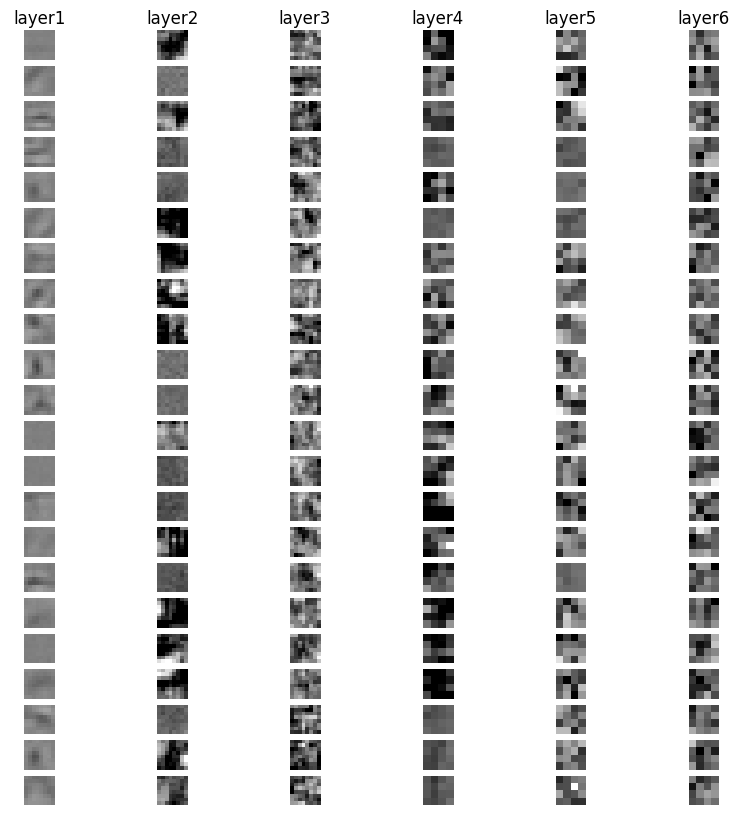

In [3]:
## QUANTISATION

# Makes the symmetrical quantisation of the coefficients for an FPGA computations
# 
def quantize_tensor_val(var_name, sess, q_dec_val=128.0, type_q = tf.qint16):
    var_name_q = tf.quantize_v2(var_name, -q_dec_val, q_dec_val, type_q).output;
    var_name_q_val = sess.run([ var_name_q], feed_dict = { })
    return np.squeeze(var_name_q_val);

# symmetricla quantization
# e.g. fixed point 6.10
q_dec_val = 512.0; # maximal integer value that could be represented
type_q = tf.qint16;
numbits = 16;

print('Quantizing in the format of signed fixed point ', int(np.log2(q_dec_val)), '.', int(numbits - np.log2(q_dec_val) ))

Wc1_q_val = quantize_tensor_val(Wc1, sess)
Wc2_q_val = quantize_tensor_val(Wc2, sess)
Wc3_q_val = quantize_tensor_val(Wc3, sess)
Wc4_q_val = quantize_tensor_val(Wc4, sess)
Wc5_q_val = quantize_tensor_val(Wc5, sess)
Wc6_q_val = quantize_tensor_val(Wc6, sess)

#plotting extracted quantized features (W)

filt13 = np.zeros([3,22, 8, 8]);
filt46 = np.zeros([3,22, 4, 4]);

Wc1_q_val = Wc1_q_val.swapaxes(0,1);
Wc1_q_val = Wc1_q_val.swapaxes(0,2);
Wc2_q_val = Wc2_q_val.swapaxes(2,3);
Wc2_q_val = Wc2_q_val.swapaxes(3,0);
Wc3_q_val = Wc3_q_val.swapaxes(2,3);
Wc3_q_val = Wc3_q_val.swapaxes(3,0);
Wc4_q_val = Wc4_q_val.swapaxes(2,3);
Wc4_q_val = Wc4_q_val.swapaxes(3,0);
Wc5_q_val = Wc5_q_val.swapaxes(2,3);
Wc5_q_val = Wc5_q_val.swapaxes(3,0);
Wc6_q_val = Wc6_q_val.swapaxes(2,3);
Wc6_q_val = Wc6_q_val.swapaxes(3,0);

filt13[0,:,:,:] = Wc1_q_val[:][:][:];
filt13[1,:,:,:] = Wc2_q_val[:,:,:,:].sum(axis=0).swapaxes(0,1);
filt13[2,:,:,:] = Wc3_q_val[:,:,:,:].sum(axis=0).swapaxes(0,1);
filt46[0,:,:,:] = Wc4_q_val[:,:,:,:].sum(axis=0).swapaxes(0,1);
filt46[1,:,:,:] = Wc5_q_val[:,:,:,:].sum(axis=0).swapaxes(0,1);
filt46[2,:,:,:] = Wc6_q_val[:,:,:,:].sum(axis=0).swapaxes(0,1);

print('W1-3 max',np.abs(filt13).max())
print('W4-6 max',np.abs(filt46).max())

plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
for i in range(22):
    for j in range(3): 
        plt.subplot( 22, 6, 6*i+j+1)
        plt.imshow(filt13[j,i,:,:], vmin=-q_dec_val,vmax=q_dec_val)
        plt.axis('off')
        if(i==0):
            plt.title('layer'+str(j+1))
        
        plt.subplot( 22, 6, 6*i+j+4)
        plt.imshow(filt46[j,i,:,:], vmin=-q_dec_val,vmax=q_dec_val)
        plt.axis('off')
        if(i==0):
            plt.title('layer'+str(j+4))
            

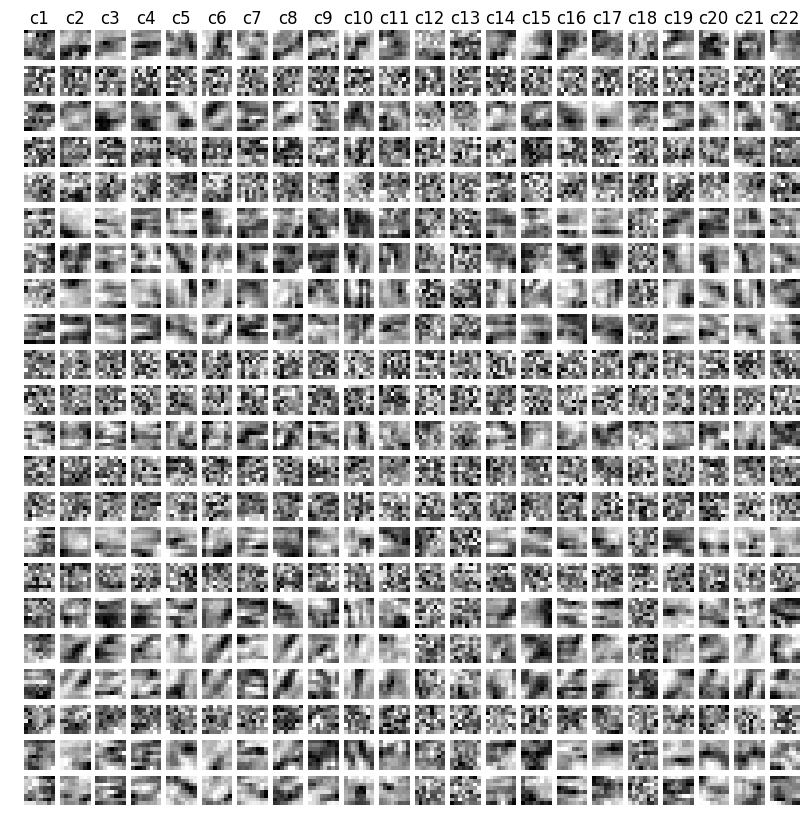

In [4]:
# plotting ALL Wc2 folters
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
for i in range(22):
    for j in range(22): 
        plt.subplot( 22, 22, 22*i+j+1)
        plt.imshow(Wc2[:,:,j,i])
        plt.axis('off')
        if(i==0):
            plt.title('c'+str(j+1))
            

In [5]:
data_orig = np.ones([n_train, 48,48])
data_orig[0,:,:] = np.reshape(test_data[1], (48,48))
image = data_orig[0,:,:]
result,W1, h1, h2, h3, h4, h5, h6 = sess.run([y,W_conv1,  h_conv1, h_conv2, h_conv3, h_conv4, h_conv5, h_conv6], feed_dict={xin: data_orig.reshape((64, 48**2)), keep_prob_input: 1.0})

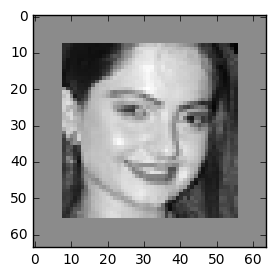

In [6]:
img = image;
kernel = np.zeros((8,8))
padding_down = np.zeros((int(kernel.shape[0]), img.shape[0]));
padding_right = np.zeros(( img.shape[1]+2*int(kernel.shape[0]), int(kernel.shape[1])));
img_padded = np.concatenate(( padding_down, img, padding_down),axis=0)
img_padded = np.concatenate((padding_right, img_padded, padding_right),axis =1)
plt.rcParams['figure.figsize'] = (3.0, 3.0) # set default size of plots
plt.imshow(img_padded)

Results after convolution 1, tensorflow


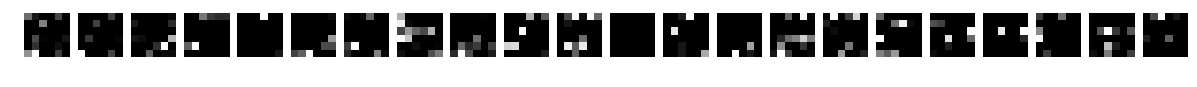

In [7]:
print('Results after convolution 1, tensorflow')
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
for i in range(22):
    plt.subplot( 1, 22, i+1)
    plt.imshow(h6[0,:,:,i])
    plt.axis('off')

Results after convolution 1, my own functions


NameError: name 'convolved6' is not defined

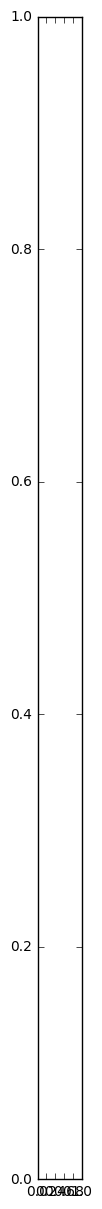

In [8]:
print('Results after convolution 1, my own functions')
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
for i in range(22):
    plt.subplot( 1, 22, i+1)
    plt.imshow(convolved6[i,:,:] - h6[0,:,:,i])
    plt.axis('off')
    print(np.max((convolved6[i,:,:] - h6[0,:,:,i])))

In [39]:
# finalized alghorithm
from skimage.measure import block_reduce

#ReLU operator (simply zeroing the negative part of the matrix)
def ReLU(img):
    img2 = img.reshape(np.size(img));
    img2[ img2 < 0.0 ] = 0.0;
    return img2.reshape(img.shape)

# SoftMax Operator to calculate the result
def SoftMax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

# made my own function, because the tensorflow convolution is non-standard
def conv2d_single( img, kernel):
    output = np.zeros((img.shape[0],img.shape[1]))
    
    # adding the padding
    #padding_down = np.zeros((int(kernel.shape[0]), img.shape[0]));
    #padding_right = np.zeros(( img.shape[1]+2*int(kernel.shape[0]), int(kernel.shape[1])));
    #img_padded = np.concatenate(( padding_down, img, padding_down),axis=0)
    #img_padded = np.concatenate((padding_right, img_padded, padding_right),axis =1)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]): #kernel operation for (i,j) pixel
            for di in range( kernel.shape[0]):
                for dj in range(kernel.shape[1]):
                    x_ind = i + di-int(kernel.shape[0]/2)+1;
                    y_ind = j + dj-int(kernel.shape[1]/2)+1;
                    if(x_ind >= 0) and (x_ind<img.shape[0]) and (y_ind >= 0) and (y_ind<img.shape[1]):
                        output[i, j] = output[i, j] + img[  x_ind, y_ind] * kernel[di, dj]
    return output;

def maxpool2x2(img):
    output = np.zeros((img.shape[0]/2, img.shape[1]/2));
    for i in range(int(img.shape[0]/2)):
        for j in range(int(img.shape[1]/2)):
            output[i,j] = np.max((img[2*i:2*i+1, 2*j:2*j+1]));
    return output;
            

## Full alghorithm
convolved1   = np.zeros((22,48,48))
convolved2   = np.zeros((22,48,48))
convolved2_p = np.zeros((22,24,24))
convolved3   = np.zeros((22,24,24))
convolved4   = np.zeros((22,24,24))
convolved4_p1 = np.zeros((22,12 , 12))
convolved4_p2 = np.zeros((22,6 , 6))
convolved5   = np.zeros((22,6 , 6))
convolved6   = np.zeros((22,6 , 6))
results      = np.zeros(6)

## LAYER 1 ##
for i in range(22):
    convolved1[i,:,:] = conv2d_single(image, Wc1[:,:,0,i]) + b_c1[0][i]; # 1st layer, single convolution without accumulation
    convolved1[i,:,:] = ReLU(convolved1[i,:,:])     #ReLU (simple remove negative operation)

## LAYER 2 ##
for i in range(22):
    for j in range(22):  #accumulating convolutions for each row
        convolved2[i,:,:] = convolved2[i,:,:] +  conv2d_single(convolved1[j,:,:], Wc2[:,:,j,i]) #single convolution operation
    convolved2[i,:,:] = ReLU( convolved2[i,:,:] + b_c2[0][i] )    #ReLU (simple remove negative operation)
    convolved2_p[i,:,:] = maxpool2x2(convolved2[i,:,:])    #maxpooling 2x2
    
## LAYER 3 ##
for i in range(22):
    for j in range(22):  #accumulating convolutions for each row
        convolved3[i,:,:] = convolved3[i,:,:] +  conv2d_single(convolved2_p[j,:,:], Wc3[:,:,j,i]) #single convolution operation
    convolved3[i,:,:] = ReLU( convolved3[i,:,:] )    #ReLU (simple remove negative operation)

print('l3')
## LAYER 4 ##
for i in range(22):
    for j in range(22):  #accumulating convolutions for each row
        convolved4[i,:,:] = convolved4[i,:,:] +  conv2d_single(convolved3[j,:,:], Wc4[:,:,j,i]) #single convolution operation

    convolved4[i,:,:] = ReLU( convolved4[i,:,:] + b_c4[0][i] )    #ReLU (simple remove negative operation)
    convolved4_p1[i,:,:] = maxpool2x2(convolved4[i,:,:])    #maxpooling 2x2
    convolved4_p2[i,:,:] = maxpool2x2(convolved4_p1[i,:,:])  #maxpooling 2x2
    
## LAYER 5 ##
for i in range(22):
    for j in range(22):  #accumulating convolutions for each row
        convolved5[i,:,:] = convolved5[i,:,:] +  conv2d_single(convolved4_p2[j,:,:], Wc5[:,:,j,i]) #single convolution operation
    
    convolved5[i,:,:] = ReLU( convolved5[i,:,:] + b_c5[0][i] )    #ReLU (simple remove negative operation)
    
## LAYER 6 ##
for i in range(22):
    for j in range(22):  #accumulating convolutions for each row
        convolved6[i,:,:] = convolved6[i,:,:] +  conv2d_single(convolved5[j,:,:], Wc6[:,:,j,i]) #single convolution operation
    convolved6[i,:,:] = ReLU( convolved6[i,:,:] + b_c6[0][i] )    #ReLU (simple remove negative operation)

## END OF CONVOLUTIONS ##
    
# CALCULATING THE RESULT
results = np.matmul(convolved6.reshape((792)), Wnorm6);
results = SoftMax(results) # <-- 6 emotion probabilities here

/Users/patryk/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


l3


In [ ]:
results = np.matmul(convolved6.reshape((792)), Wnorm6);
results = SoftMax(results) # <-- 6 emotion probabilities here

In [ ]:
print(2*5+1)

In [ ]:
plt.rcParams['figure.figsize'] = (17.0, 17.0) # set default size of plots
for i in range(22):
    plt.subplot( 6, 22, 0*22 + i+1)
    plt.imshow(convolved1[i,:,:])
    plt.axis('off')
    if i == 11:
        plt.title('Result after L 1 max:' + str(convolved1.max()))
    plt.subplot( 6, 22, 1*22 + i+1)
    plt.imshow(convolved2[i,:,:])
    plt.axis('off')
    if i == 11:
        plt.title('Result after L 2 max:' + str(convolved2.max()))
    plt.subplot( 6, 22, 2*22 + i+1)
    plt.imshow(convolved3[i,:,:])
    plt.axis('off')
    if i == 11:
        plt.title('Result after L 3 max:' + str(convolved3.max()))
    plt.subplot( 6, 22, 3*22 + i+1)
    plt.imshow(convolved4[i,:,:])
    plt.axis('off')
    if i == 11:
        plt.title('Result after L 4 max:' + str(convolved4.max()))
    plt.subplot( 6, 22, 4*22 + i+1)
    plt.imshow(convolved5[i,:,:])
    plt.axis('off')
    if i == 11:
        plt.title('Result after L 5 max:' + str(convolved5.max()))
    plt.subplot( 6, 22, 5*22 + i+1)
    plt.imshow(convolved6[i,:,:])
    plt.axis('off')
    if i == 11:
plt.rcParams['figure.figsize'] = (17.0, 17.0) # set default size of plots
for i in range(22):
    plt.subplot( 6, 22, 0*22 + i+1)
    plt.imshow(convolved1[i,:,:])
    plt.axis('off')
    if i == 11:
        plt.title('Result after L 1 max:' + str(convolved1.max()))        plt.title('Result after L 6 max:' + str(convolved6.max()))

In [ ]:
%matplotlib inline
from IPython.display import clear_output
#faces, marked_img = ut.get_faces_from_img('diff_emotions.jpg');
#faces, marked_img = ut.get_faces_from_img('big_bang.png');
plt.rcParams['figure.figsize'] = (5.0,5.0) # set default size of plots

while(1): # 2, 5
    faces, marked_img = ut.get_faces_from_img('camera');
    # if some face was found in the image
    print('found ' + str(len(faces)))
    if(len(faces)):      
        #creating the blank test vector
        data_orig = np.zeros([n_train, 48,48])

        #putting face data into the vector (only first few)
        for i in range(0, len(faces)):
            data_orig[i,:,:] = ut.contrast_stretch(faces[i,:,:]);

            #preparing image and putting it into the batch 

            n = data_orig.shape[0];
            data = np.zeros([n,48**2])
            for i in range(n):
                xx = data_orig[i,:,:]
                xx -= np.mean(xx)
                xx /= np.linalg.norm(xx);
                data[i,:] = xx.reshape(2304); #np.reshape(xx,[-1])
                
        nr_faces = len(faces);
        
        for i in range(0, nr_faces):
            emotion_nr = np.argmax(result[0][i]);
            plt.subplot( nr_faces, 2, (2*i)+1)
            plt.imshow(np.reshape(data[i,:], (48,48)))
            plt.axis('off')
            plt.title(str_emotions[emotion_nr])
            ax = plt.subplot(nr_faces, 2, (2*i)+2)
            ax.bar(np.arange(nc) , result[0][i])
            ax.set_xticklabels(str_emotions, rotation=45, rotation_mode="anchor")
            ax.set_yticks([])
        clear_output()
        plt.show()
        image = np.reshape(data[i,:], (48,48));
        # comment the line below for single execution
        # break;
        
    

In [ ]:
file = open('test.txt', 'w');
file.write('lalal')
file.write('lalal')
file.close()

In [23]:
# Prints a multidimentional array arr in C-Style.
# file must be already open 
def printdim(arr, file):
    if(np.size(np.shape(arr)) == 1):
        file.write('{');
        for i in range(np.shape(arr)[0]):
            file.write(str(arr[i]));
            if( i < np.shape(arr)[0] -1):
                file.write(',');
        file.write('}\n');
    else:
        file.write('{');
        for i in range(np.shape(arr)[0]):
            printdim(arr[i], file)
            if( i < np.shape(arr)[0] -1):
                file.write(',');
        file.write('}');
        

In [24]:
a = (((1,2,3),(4,5,6),(1,2,3),(4,5,6)), ((1,2,3),(4,5,6),(1,2,3),(4,5,6)))
print(np.shape(a))
file = open('test.txt', 'w');
printdim(a, file)
file.close()


(2, 4, 3)


IndexError: tuple index out of range

In [29]:
np.shape(Wc2.squeeze())

(8, 8, 22, 22)

In [10]:
# print a variable ready to put into the code
def print_as_C_array(file,arr, type_str, name_str):
    file.write('\n');
    file.write(type_str);
    file.write(' ');
    file.write(name_str);
    for i in range(np.size(np.shape(arr))):
        file.write('[')
        file.write(str(np.shape(arr)[i]))
        file.write(']')
    file.write(' = ')
    printdim(arr, file)
    file.write(';')


In [35]:
file = open('cnn_constants.h', 'a');


print_as_C_array(file,Wc1.squeeze(),'const float', 'Wc1')
print_as_C_array(file,Wc2.squeeze(),'const float', 'Wc2')
print_as_C_array(file,Wc3.squeeze(),'const float', 'Wc3')
print_as_C_array(file,Wc4.squeeze(),'const float', 'Wc4')
print_as_C_array(file,Wc5.squeeze(),'const float', 'Wc5')
print_as_C_array(file,Wc6.squeeze(),'const float', 'Wc6')

print_as_C_array(file,Wnorm6.squeeze(),'const float', 'Wn6')

print_as_C_array(file,np.squeeze(b_c1),'const float', 'bc1')
print_as_C_array(file,np.squeeze(b_c2),'const float', 'bc2')
print_as_C_array(file,np.squeeze(b_c3),'const float', 'bc3')
print_as_C_array(file,np.squeeze(b_c4),'const float', 'bc4')
print_as_C_array(file,np.squeeze(b_c5),'const float', 'bc5')
print_as_C_array(file,np.squeeze(b_c6),'const float', 'bc6')
print_as_C_array(file,np.squeeze(b_n6),'const float', 'bn6')
file.close()

IndexError: index 8 is out of bounds for axis 0 with size 8

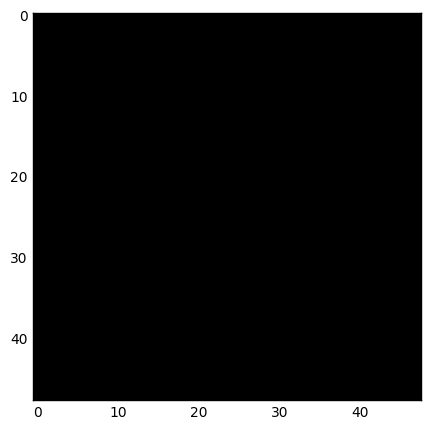

In [38]:
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.imshow(convolved1[0,:,:])

In [ ]:
file = open('example_face.h', 'a');
print_as_C_array(file,img,'const float', 'face1')
file.close()

In [32]:
Wc1p = np.squeeze(Wc1).swapaxes(0,2);
print(np.shape(Wc1p))

Wc2p = np.squeeze(Wc2).swapaxes(1,2).swapaxes(0,3);
print(np.shape(Wc2p))

Wc3p = np.squeeze(Wc3).swapaxes(1,2).swapaxes(0,3);
print(np.shape(Wc3p))

Wc4p = np.squeeze(Wc4).swapaxes(1,2).swapaxes(0,3);
print(np.shape(Wc4p))

Wc5p = np.squeeze(Wc5).swapaxes(1,2).swapaxes(0,3);
print(np.shape(Wc5p))

Wc6p = np.squeeze(Wc6).swapaxes(1,2).swapaxes(0,3);
print(np.shape(Wc6p))

(22, 8, 8)
(22, 22, 8, 8)
(22, 22, 8, 8)
(22, 22, 4, 4)
(22, 22, 4, 4)
(22, 22, 4, 4)


In [34]:
file = open('cnn_constants.h', 'a');
print_as_C_array(file,Wc1p.squeeze(),'const float', 'Wc1')
print_as_C_array(file,Wc2p.squeeze(),'const float', 'Wc2')
print_as_C_array(file,Wc3p.squeeze(),'const float', 'Wc3')
print_as_C_array(file,Wc4p.squeeze(),'const float', 'Wc4')
print_as_C_array(file,Wc5p.squeeze(),'const float', 'Wc5')
print_as_C_array(file,Wc6p.squeeze(),'const float', 'Wc6')

print_as_C_array(file,Wnorm6.squeeze(),'const float', 'Wn6')

print_as_C_array(file,np.squeeze(b_c1),'const float', 'bc1')
print_as_C_array(file,np.squeeze(b_c2),'const float', 'bc2')
print_as_C_array(file,np.squeeze(b_c3),'const float', 'bc3')
print_as_C_array(file,np.squeeze(b_c4),'const float', 'bc4')
print_as_C_array(file,np.squeeze(b_c5),'const float', 'bc5')
print_as_C_array(file,np.squeeze(b_c6),'const float', 'bc6')
print_as_C_array(file,np.squeeze(b_n6),'const float', 'bn6')
file.close()